In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
! kaggle competitions download -c digit-recognizer

 85% 13.0M/15.3M [00:01<00:00, 14.2MB/s]
100% 15.3M/15.3M [00:01<00:00, 8.99MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/digit-recognizer.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Load the training and test data from CSV files
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')


In [ ]:
train.shape, test.shape

((42000, 785), (28000, 784))

In [ ]:
X_train = train.drop('label',axis=1)
y_train = train['label']

X_test = test.copy()

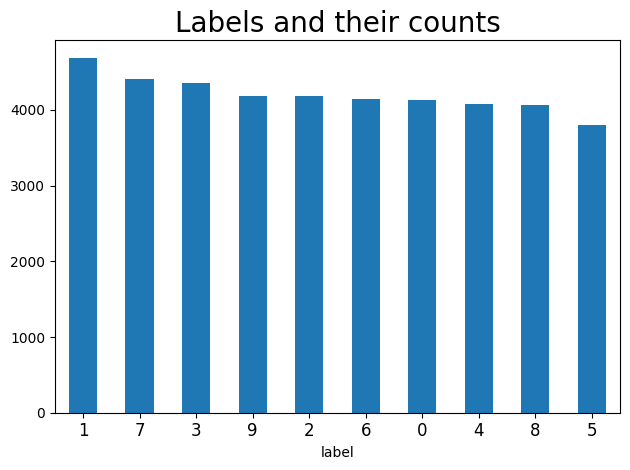

In [ ]:
y_train.value_counts().plot(kind='bar',legend=None)
plt.xticks(fontsize=12,rotation=0)

plt.title('Labels and their counts',fontsize=20)

plt.tight_layout()

In [ ]:
# Normalize the data
X_train = X_train / 255.0
X_test  = X_test / 255.0

In [ ]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_test  = X_test.values.reshape(-1,28,28,1)

Text(0.5, 1.0, 'Label: 0')

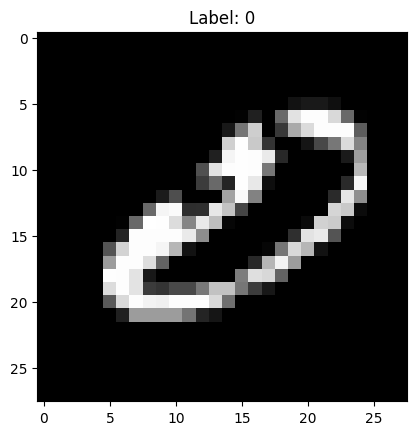

In [ ]:
classes = y_train.unique().astype(str)

i = np.random.choice(len(X_train))
plt.imshow(X_train[i],cmap='gray')
plt.title(f"Label: {y_train[i]}")

In [ ]:
# Train-validation splitting
X_train2,X_validation,y_train2,y_validation = train_test_split(X_train,y_train,
                                                             test_size=0.3,random_state=0)

In [ ]:
# Define the optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9,epsilon=1e-08,decay=0.0)

# Defining the learning rate reduction routine
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0000001)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# Defining the checkpoint callback
checkpoint_path = "results.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_freq='epoch')

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=5,         # Randomly rotate images by up to 5 degrees
        zoom_range=0.1,            # Randomly zoom images by up to 10%
        width_shift_range=0.1,     # Randomly shift images horizontally by up to 10% of width
        height_shift_range=0.1,    # Randomly shift images vertically by up to 10% of height
        shear_range= 0.1,
        fill_mode='nearest'
)

datagen.fit(X_train2)

In [ ]:
tf.random.set_seed(42)

DROPOUT = 0.3

model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=X_train[0].shape),
        ### First block of layers ###
        tf.keras.layers.Conv2D(32, (3,3), activation="leaky_relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3,3), activation="leaky_relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(DROPOUT),
        ### Second block of layers ###
        tf.keras.layers.Conv2D(64, (3,3), activation="leaky_relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), activation="leaky_relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(DROPOUT),
        ### Third block of layers ###
        tf.keras.layers.Conv2D(128, (3,3), activation="leaky_relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3,3), activation="leaky_relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(DROPOUT),
        ### Fourth block of layers ###
        tf.keras.layers.Conv2D(256, (3,3), activation="leaky_relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3,3), activation="leaky_relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(DROPOUT),
        ### Final layers before output ###
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(DROPOUT),
        tf.keras.layers.Dense(256, activation="leaky_relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation="softmax")
])

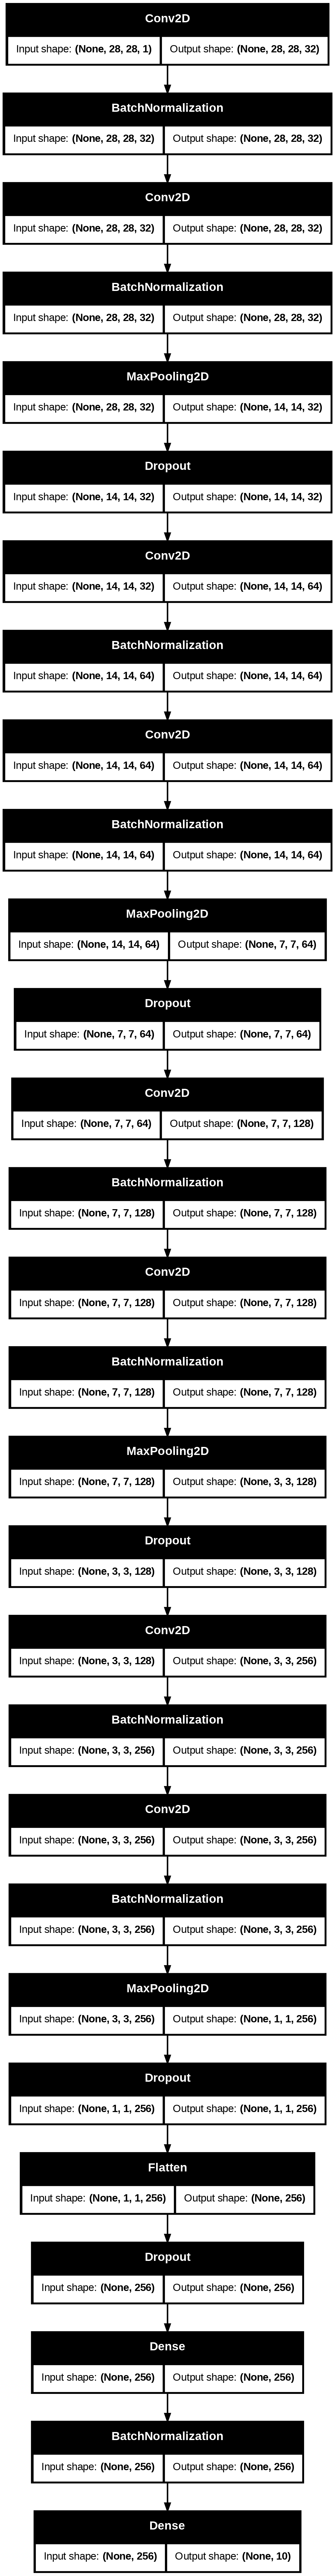

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')

In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=optimizer,
                 metrics=["accuracy"])

# Fit the model
history = model.fit(datagen.flow(X_train2,y_train2,batch_size=32),
                      epochs=45,
                      validation_data=(X_validation,y_validation),
                      callbacks=[learning_rate_reduction,checkpoint_callback])

Epoch 1/45


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


915/919 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7957 - loss: 0.6298
Epoch 1: val_accuracy improved from -inf to 0.94563, saving model to results.weights.h5
919/919 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.7962 - loss: 0.6282 - val_accuracy: 0.9456 - val_loss: 0.2078 - learning_rate: 0.0010
Epoch 2/45
915/919 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9603 - loss: 0.1415
Epoch 2: val_accuracy improved from 0.94563 to 0.97786, saving model to results.weights.h5
919/919 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9603 - loss: 0.1414 - val_accuracy: 0.9779 - val_loss: 0.0742 - learning_rate: 0.0010
Epoch 3/45
918/919 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9710 - loss: 0.0994
Epoch 3: val_accuracy improved from 0.97786 to 0.98770, saving model to results.weights.h5
919/919 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9710 - loss: 0.0994 - val_accuracy: 0.9877 - val_loss: 0.0460 - learning_rate: 0.0010
Epoch 4/45
915/919 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/ste

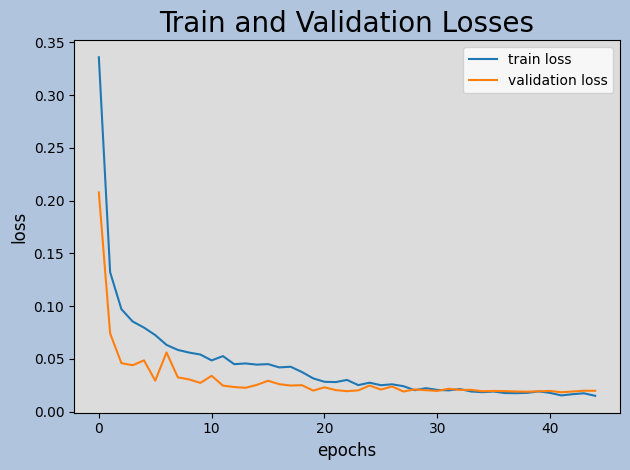

In [ ]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('epochs',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.legend()

plt.title('Train and Validation Losses',fontsize=20)

plt.tight_layout()
plt.gca().set_facecolor('gainsboro')
plt.gcf().patch.set_facecolor('lightsteelblue')

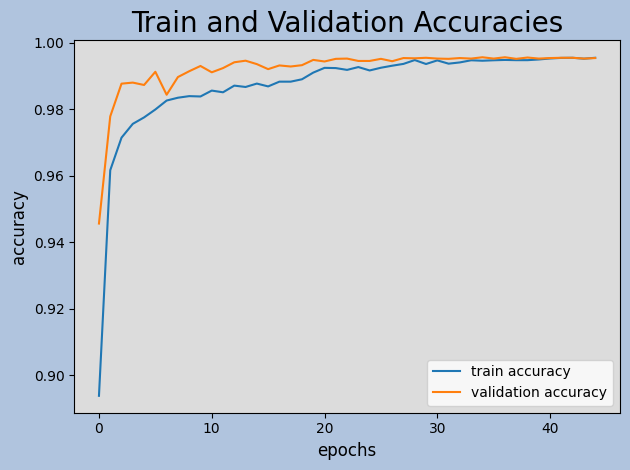

In [ ]:
plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epochs',fontsize=12)
plt.ylabel('accuracy',fontsize=12)
plt.legend()

plt.title('Train and Validation Accuracies',fontsize=20)

plt.tight_layout()
plt.gca().set_facecolor('gainsboro')
plt.gcf().patch.set_facecolor('lightsteelblue')

In [ ]:
score = model.evaluate(X_validation,y_validation,verbose=0)
print('Test Loss: {:.4f}'.format(score[0]))
print('Test Accuracy: {:.4f}'.format(score[1]))

Test Loss: 0.0198
Test Accuracy: 0.9954


In [ ]:
# These are the predicted class probabilities (probs)
y_probs = model.predict(X_validation)

# I am printing the first prediction.
y_probs[0]

394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


array([5.4492455e-10, 3.2652395e-10, 7.4588552e-10, 1.0000000e+00,
       5.9878857e-10, 1.5912390e-09, 1.5562143e-09, 1.0258382e-09,
       3.0737807e-10, 4.8411991e-10], dtype=float32)

In [ ]:
# The probs need to be converted in the predicted labels
# by choosing the highest probability in the list
pred_labels = y_probs.argmax(axis=1)
pred_labels

array([3, 6, 9, ..., 1, 6, 5])

In [ ]:
cm = confusion_matrix(y_validation,pred_labels)
plt.show()

In [ ]:
results = model.predict(X_test)

# select the indix with the maximum probability
results = np.argmax(results, axis=1)

results = pd.Series(results, name="Label")

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission

# submission.to_csv("cnn_mnist_results.csv",index=False)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
